# Using `ArviZ` for Plotting and Chain Statistics

I wrote up a short example for using `ArviZ` to examine MCMC chains. The plotting is fairly nice, but the main usefulness I think comes with the different convergence and diagnostic tests. Most of the tests need multiple chains to work, so keep that in mind. There are also way more options than I put here, but this is just a start!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os, glob
from collections import OrderedDict
import numpy as np
import arviz as az
import la_forge.core as co
import la_forge.diagnostics as dg
from enterprise.pulsar import Pulsar

import warnings
warnings.filterwarnings('ignore')

# 5-yr Examples

To give the chains and their corresponding parameters to `ArviZ`, I found that the easiest way is to associate each chain/posterior with the name of the parameter. So I use the same parameters as in `la_forge`'s `fancy_par_names` as the dict keys, then use `get_param` to pull out the corresponding chain and assign them as the dict values. To convert to the `ArviZ` format, you can just call `az.convert_to_inference_data` on the created dictionary.

To see the summary of each parameters' chain, you can call `az.summary`. To select particular parameters you just pick out the `var_names` that correspond to the dictionary keys.

The less obvious columns correspond to:
* `hpd`:  highest posterior density (HPD) of array for given credible_interval

`plot_trace` give the distribution and the traceplot all in nice subplots.
If you have multiple of the same runs, `plot_trace` will overplot the two. Plus, with multiple "identical" runs, `ArviZ` can start running diagnostics on the the two chains.

This function makes a corner plot for the data, the variable selection is the same as above. You can also change the style with kind: 'kde' are smooth, 'scatter' are individual points in the parameter space, and 'hexbin' bins the data into hex bins

If you don't want to use `la_forge`, you can also load in the chains this way. In addition to the parameter names I defined earlier, you can also just load in the `pars.txt` file in the chain directory

```
chain_J2317_tm_run_1 = np.loadtxt(chaindir_J2317_tm_run_1 + '/chain_1.txt')
burn_J2317_tm_run_1 = int(0.25 * chain_J2317_tm_run_1.shape[0])
chain_J2317_tm_run_1 = chain_J2317_tm_run_1[burn_J2317_tm_run_1:]

chain_dict_J2317_tm_run_1 = {}
for i,par in enumerate(tmparam_list_J2317):
    chain_dict_J2317_tm_run_1[par] = chain_J2317_tm_run_1[:,i]
az_J2317_from_chains = az.convert_to_inference_data(chain_dict_J2317_tm_run_1)
```

In [3]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

#psr = 'J2317+1439'
psr = 'J1909-3744'
num_chains = 2

psrlist = [psr]
datadir = top_dir + '/5yr/NANOGrav_dfg+12_20120911'

parfiles = sorted(glob.glob(datadir + '/par/*.par'))
timfiles = sorted(glob.glob(datadir + '/tim/*.tim'))

# filter
parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]
timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]

epsr = Pulsar(parfiles[0], timfiles[0], ephem='DE436', clk=None, drop_t2pulsar=False)
"""psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE436', clk=None, drop_t2pulsar=False)
    psrs.append(psr)"""

"psrs = []\nfor p, t in zip(parfiles, timfiles):\n    psr = Pulsar(p, t, ephem='DE436', clk=None, drop_t2pulsar=False)\n    psrs.append(psr)"

In [4]:
pardict = {}
for par,vals,errs in zip(epsr.fitpars[1:],epsr.t2pulsar.vals(),epsr.t2pulsar.errs()):
    pardict[par] = {}
    pardict[par]['val'] = vals
    pardict[par]['err'] = errs

# Multiple Chains

If you want to compare multiple of the same runs, you will need to load in the other chains and combine them in a different dictionary to load into `ArviZ`.

In [5]:
"""tmparam_list = [r'327G_ASP Efac', '327G_ASP $\mathrm{log}_{10}$Ecorr',
                        '327G_ASP $\mathrm{log}_{10}$Equad', '430G_ASP Efac',
                        '430G_ASP $\mathrm{log}_{10}$Ecorr', '430G_ASP $\mathrm{log}_{10}$Equad',
                        'Red Noise Gamma','Red Noise $\mathrm{log}_{10}$A',
                        'PBDOT',
                        'PB','A1', 'EPS1', 'EPS2', 'EPS1DOT', 'EPS2DOT',
                        'PMRA', 'PMDEC',
                        'RAJ', 'DECJ','PX',
                        'F0', 'F1',
                        'lnlike','lnprior', 'chain accept', 'pt chain accept']"""
tmparam_list = [r'Rcvr1_2_GASP Efac', 'Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr',
                        'Rcvr1_2_GASP $\mathrm{log}_{10}$Equad', 'Rcvr_800_GASP Efac',
                        'Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr', 'Rcvr_800_GASP $\mathrm{log}_{10}$Equad',
                        'Red Noise Gamma','Red Noise $\mathrm{log}_{10}$A',
                        'PBDOT',
                        'PB','A1', 'EPS1', 'EPS2', 'M2',
                        'PMRA', 'PMDEC',
                        'RAJ', 'DECJ','PX',
                        'F0', 'F1',
                        'lnlike','lnprior', 'chain accept', 'pt chain accept']

use_tmparam_list = True
chaindir_list = []
big_chaindir = os.getcwd()+'/chains/{}_all_var_3'.format(psr)
for i in range(num_chains):
    chaindir_list.append(os.getcwd()+'/chains/{}_all_var_{}'.format(psr,i+1))

In [6]:
print(chaindir_list)

['/Users/andrewkaiser/Documents/GradSchool/Research/nanograv/NANOGrav/enterprise_timing/chains/J1909-3744_all_var_1', '/Users/andrewkaiser/Documents/GradSchool/Research/nanograv/NANOGrav/enterprise_timing/chains/J1909-3744_all_var_2']


In [7]:
chain_list = []
for chaindir in chaindir_list:
    chain = np.loadtxt(chaindir + '/chain_1.txt')
    burn = int(0.25 * chain.shape[0])
    chain_list.append(chain[burn:])

In [8]:
big_chain = np.loadtxt(big_chaindir + '/chain_1.txt')
big_burn = int(0.25 * big_chain.shape[0])
big_chain = big_chain[big_burn:]

In [9]:
division = 10
offset = 0
small_chain_len = chain_list[0].shape[0]
big_chain_len = len(big_chain)
division = int(big_chain_len/small_chain_len)
offset = big_chain_len-division*small_chain_len
offset_chain = big_chain[offset:]
for i in range(division):
    chain_list.append(offset_chain[i*small_chain_len:(i+1)*small_chain_len])

In [10]:
print(np.shape(chain_list))

(12, 7425, 25)


In [11]:
chain_dict = {} 
for i,par in enumerate(tmparam_list):
    for chain in chain_list:
        if par in chain_dict.keys():
            chain_dict[par] = np.concatenate((chain_dict[par],[chain[:,i]]),axis=0)
        else:
            chain_dict[par] = [chain[:,i]]
az_comb = az.convert_to_inference_data(chain_dict)

In [12]:
print(az_comb.posterior)

<xarray.Dataset>
Dimensions:                                 (chain: 12, draw: 7425)
Coordinates:
  * chain                                   (chain) int64 0 1 2 3 ... 8 9 10 11
  * draw                                    (draw) int64 0 1 2 ... 7423 7424
Data variables:
    Rcvr1_2_GASP Efac                       (chain, draw) float64 1.111 ... 0.9694
    Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr   (chain, draw) float64 -8.237 ... -7.807
    Rcvr1_2_GASP $\mathrm{log}_{10}$Equad   (chain, draw) float64 -8.432 ... -7.614
    Rcvr_800_GASP Efac                      (chain, draw) float64 1.18 ... 1.156
    Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr  (chain, draw) float64 -7.219 ... -8.229
    Rcvr_800_GASP $\mathrm{log}_{10}$Equad  (chain, draw) float64 -6.672 ... -6.677
    Red Noise Gamma                         (chain, draw) float64 4.611 ... 5.906
    Red Noise $\mathrm{log}_{10}$A          (chain, draw) float64 -12.63 ... -12.65
    PBDOT                                   (chain, draw) float

Use this handy function if you would like to know what the parameter space of your chain looks like, it will show you if you loaded in the three separate chains correctly.

In [13]:
print(az_comb.posterior)

<xarray.Dataset>
Dimensions:                                 (chain: 12, draw: 7425)
Coordinates:
  * chain                                   (chain) int64 0 1 2 3 ... 8 9 10 11
  * draw                                    (draw) int64 0 1 2 ... 7423 7424
Data variables:
    Rcvr1_2_GASP Efac                       (chain, draw) float64 1.111 ... 0.9694
    Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr   (chain, draw) float64 -8.237 ... -7.807
    Rcvr1_2_GASP $\mathrm{log}_{10}$Equad   (chain, draw) float64 -8.432 ... -7.614
    Rcvr_800_GASP Efac                      (chain, draw) float64 1.18 ... 1.156
    Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr  (chain, draw) float64 -7.219 ... -8.229
    Rcvr_800_GASP $\mathrm{log}_{10}$Equad  (chain, draw) float64 -6.672 ... -6.677
    Red Noise Gamma                         (chain, draw) float64 4.611 ... 5.906
    Red Noise $\mathrm{log}_{10}$A          (chain, draw) float64 -12.63 ... -12.65
    PBDOT                                   (chain, draw) float

Since we included multiple chains, `az.summary` can run some of the provided diagnostics.

The less obvious columns correspond to:
*  `hpd` :  Highest posterior density (HPD) of array for a given credible interval
*  `mcse` : Markov Chain Standard Error statistic
*  `ess` :  Estimate of the effective sample size
*  `r_hat` :  Estimate of rank normalized splitR-hat for a set of traces

The `ArviZ` documentation points to https://arxiv.org/abs/1903.08008 for more info on both the `ess` and `r_hat` diagnostics.

In [14]:
az.summary(az_comb,var_names=tmparam_list[:-2])
#az.summary(az_comb,var_names=core_list[0].params[:-2])

mean     sd     hpd_3%  \
Rcvr1_2_GASP Efac                           1.004  0.033      0.939   
Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr      -7.865  0.391     -8.499   
Rcvr1_2_GASP $\mathrm{log}_{10}$Equad      -8.007  0.288     -8.498   
Rcvr_800_GASP Efac                          1.127  0.059      1.012   
Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr     -7.942  0.346     -8.500   
Rcvr_800_GASP $\mathrm{log}_{10}$Equad     -6.688  0.040     -6.767   
Red Noise Gamma                             5.031  0.874      3.548   
Red Noise $\mathrm{log}_{10}$A            -12.642  0.069    -12.768   
PBDOT                                      -0.061  0.118     -0.286   
PB                                          0.023  0.049     -0.067   
A1                                         -0.031  0.120     -0.254   
EPS1                                       -0.085  0.129     -0.328   
EPS2                                       -0.071  0.177     -0.404   
M2                                          0.047  0.125     -0.184   
PMRA                                       -0.154  0.134     -0.406   
PMDEC                                      -0.305  0.158     -0.607   
RAJ                                         0.164  0.135     -0.094   
DECJ                                        0.348  0.190      0.004   
PX                                          0.129  0.079     -0.016   
F0                                          0.048  0.116     -0.168   
F1                                         -0.034  0.113     -0.248   
lnlike                                  13857.736  3.174  13851.855   
lnprior                                 13890.652  3.164  13884.833   

                                          hpd_97%  mcse_mean  mcse_sd  \
Rcvr1_2_GASP Efac                           1.062      0.001    0.000   
Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr      -7.219      0.007    0.005   
Rcvr1_2_GASP $\mathrm{log}_{10}$Equad      -7.556      0.007    0.005   
Rcvr_800_GASP Efac                          1.235      0.001    0.001   
Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr     -7.372      0.006    0.005   
Rcvr_800_GASP $\mathrm{log}_{10}$Equad     -6.615      0.001    0.001   
Red Noise Gamma                             6.796      0.020    0.014   
Red Noise $\mathrm{log}_{10}$A            -12.507      0.001    0.001   
PBDOT                                       0.159      0.003    0.002   
PB                                          0.118      0.001    0.001   
A1                                          0.198      0.003    0.002   
EPS1                                        0.157      0.004    0.003   
EPS2                                        0.252      0.003    0.002   
M2                                          0.287      0.004    0.002   
PMRA                                        0.094      0.006    0.004   
PMDEC                                      -0.024      0.007    0.005   
RAJ                                         0.413      0.006    0.004   
DECJ                                        0.705      0.009    0.006   
PX                                          0.282      0.002    0.001   
F0                                          0.265      0.002    0.002   
F1                                          0.178      0.002    0.002   
lnlike                                  13863.282      0.083    0.058   
lnprior                                 13896.229      0.082    0.058   

                                        ess_mean  ess_sd  ess_bulk  ess_tail  \
Rcvr1_2_GASP Efac                         2685.0  2679.0    2694.0    3904.0   
Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr     2746.0  2746.0    2821.0    4220.0   
Rcvr1_2_GASP $\mathrm{log}_{10}$Equad     1947.0  1947.0    1969.0    3016.0   
Rcvr_800_GASP Efac                        1909.0  1902.0    1927.0    2911.0   
Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr    2948.0  2948.0    3003.0    4826.0   
Rcvr_800_GASP $\mathrm{log}_{10}$Equad    1780.0  1779.0    1795.0    2768.0   
Red Noise Gamma            

The chains are plotted on top of one another, unless you specify the particular group you wish to examine. For example, doing `coords={'chain':[2]}` looks at the third chain.

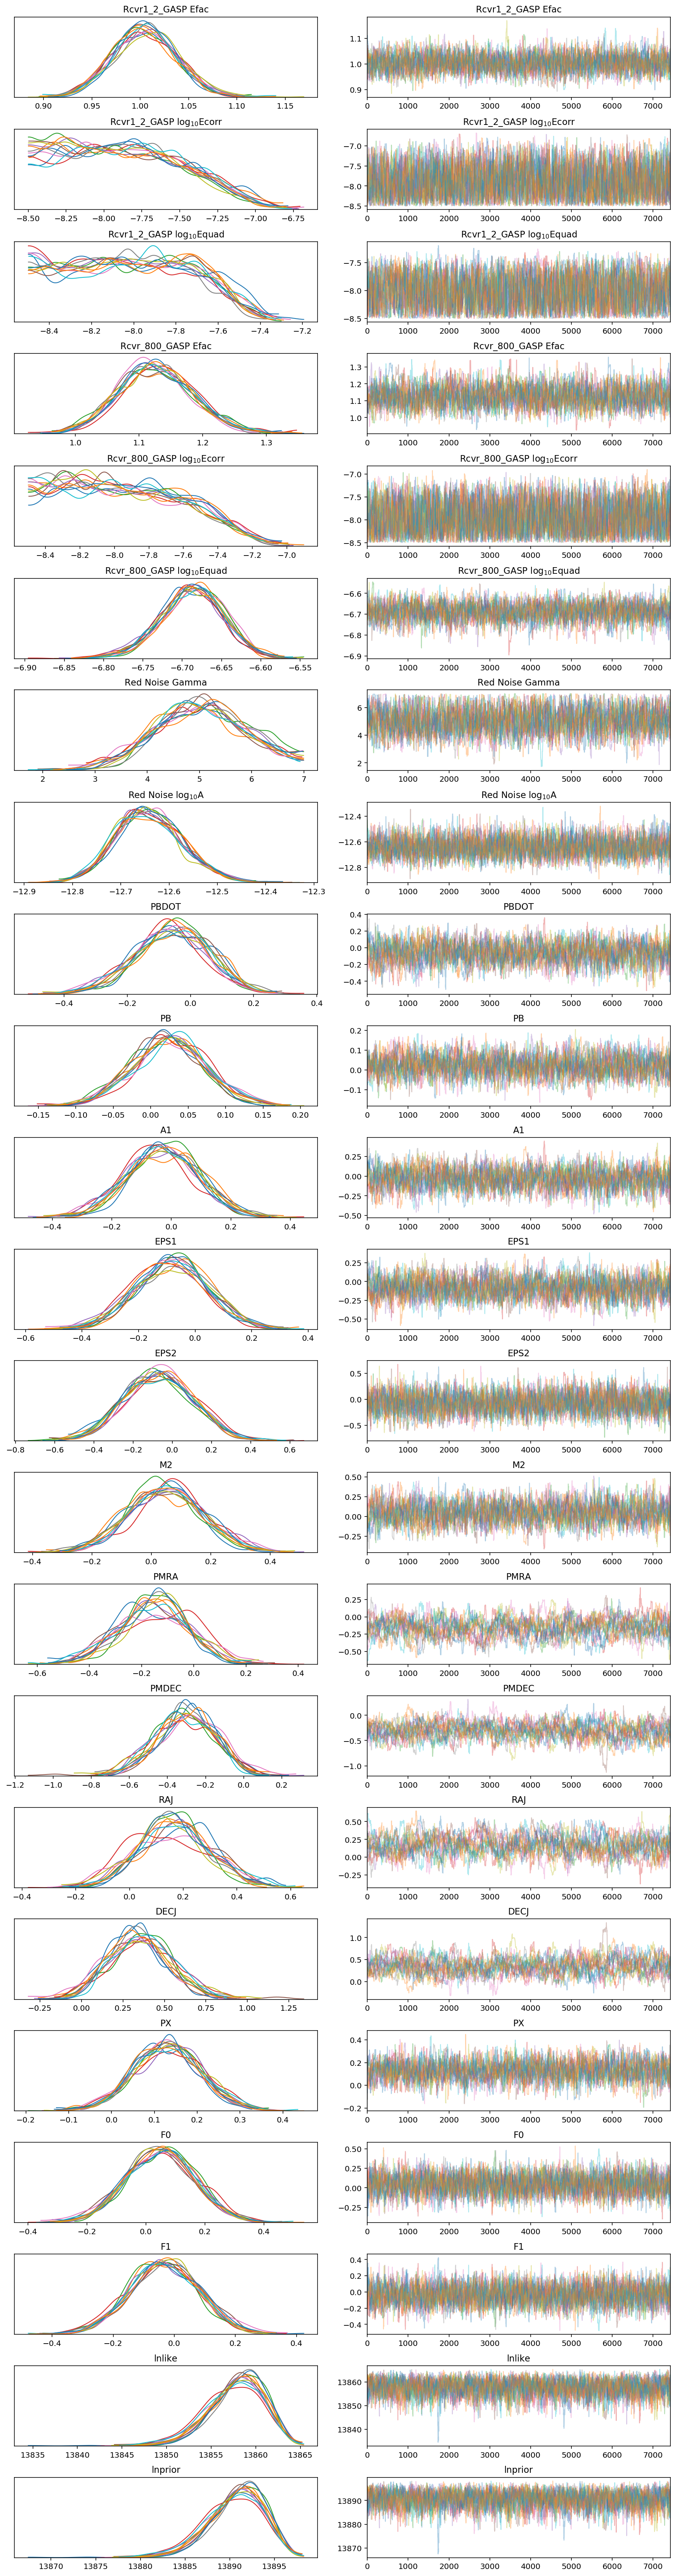

In [15]:
if use_tmparam_list:
    az.plot_trace(az_comb,
                  var_names=tmparam_list[:-2]);
                  #coords={'chain':[2]});
else:
    az.plot_trace(az_comb,
                  var_names=core_list[0].params[:-2]);
                  #coords={'chain':[2]});

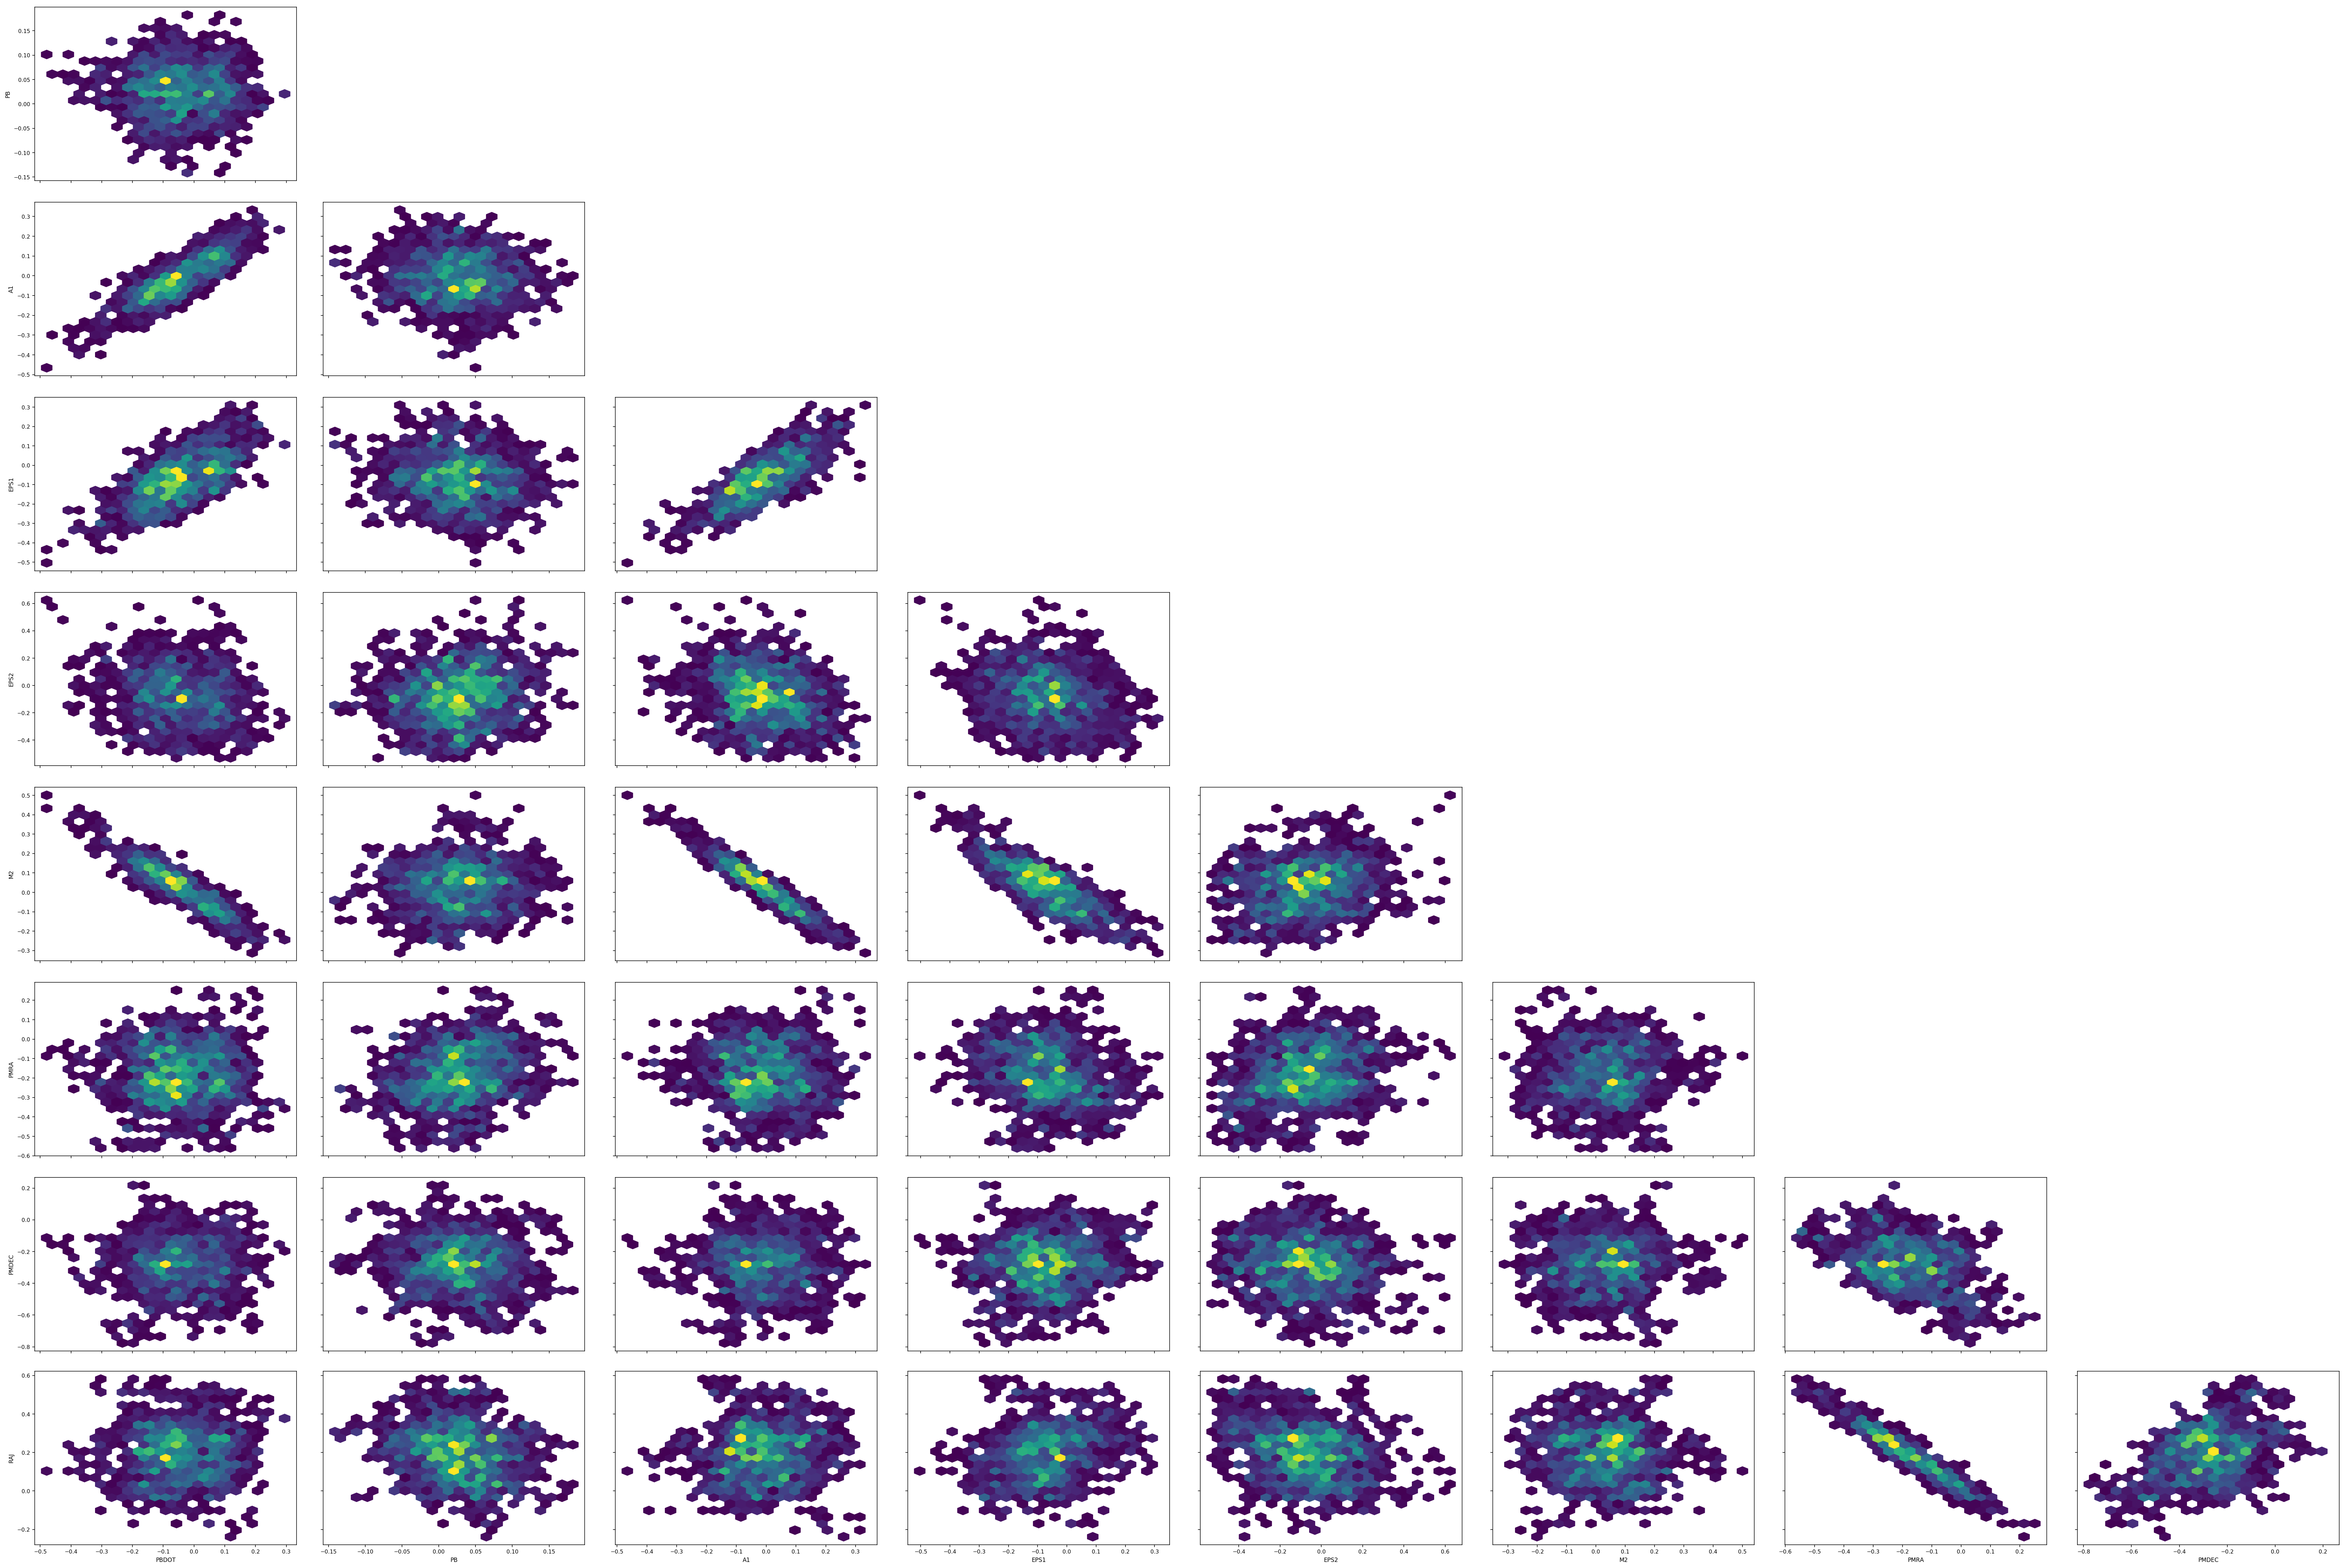

In [16]:
if use_tmparam_list:
    az.plot_pair(az_comb,
                 var_names=tmparam_list[8:-2],
                 coords={'chain':[0]},
                 kind='hexbin',
                 textsize=8);
else:
    az.plot_pair(az_comb,
             var_names=core_list[0].params[8:-2],
             coords={'chain':[0]},
             kind='hexbin',
             textsize=8);